In [1]:
# 221219 로스만 상점매출 예측

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
# 패키지
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    from xgboost import XGBRegressor
except:
    !pip install xgboost

try:
    from sklearn.model_selection import cross_val_score
except:
    !pip install sklearn

In [2]:
# 데이터
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
store = pd.read_csv("./data/store.csv")

In [3]:
# train 데이터 확인
print(train.head())
print(train.info())

      id  Store        Date  Sales  Promo StateHoliday  SchoolHoliday
0  14929     85  2015-05-01  11360      1            a              0
1  14930    512  2015-05-01  10534      1            a              0
2  14931   1097  2015-05-01  17039      1            a              0
3  14932      1  2015-04-30   6228      1            0              0
4  14933      9  2015-04-30   9717      1            0              0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62244 entries, 0 to 62243
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             62244 non-null  int64 
 1   Store          62244 non-null  int64 
 2   Date           62244 non-null  object
 3   Sales          62244 non-null  int64 
 4   Promo          62244 non-null  int64 
 5   StateHoliday   62244 non-null  object
 6   SchoolHoliday  62244 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 3.3+ MB
None


In [4]:
# test 데이터 확인
print(test.head())
print(test.info())

   id  Store        Date  Promo StateHoliday  SchoolHoliday
0   0      1  2015-07-01      1            0              0
1   1      9  2015-07-01      1            0              1
2   2     11  2015-07-01      1            0              0
3   3     12  2015-07-01      1            0              0
4   4     14  2015-07-01      1            0              1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14929 entries, 0 to 14928
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             14929 non-null  int64 
 1   Store          14929 non-null  int64 
 2   Date           14929 non-null  object
 3   Promo          14929 non-null  int64 
 4   StateHoliday   14929 non-null  object
 5   SchoolHoliday  14929 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 699.9+ KB
None


In [5]:
# 각 데이터 객체의 object 컬럼 더미 변수 생성
train = pd.get_dummies(columns=['StateHoliday'], data=train)
test = pd.get_dummies(columns=['StateHoliday'], data=test)

In [6]:
print(train.head())
print(test.head())

      id  Store        Date  Sales  Promo  SchoolHoliday  StateHoliday_0  \
0  14929     85  2015-05-01  11360      1              0               0   
1  14930    512  2015-05-01  10534      1              0               0   
2  14931   1097  2015-05-01  17039      1              0               0   
3  14932      1  2015-04-30   6228      1              0               1   
4  14933      9  2015-04-30   9717      1              0               1   

   StateHoliday_a  StateHoliday_b  StateHoliday_c  
0               1               0               0  
1               1               0               0  
2               1               0               0  
3               0               0               0  
4               0               0               0  
   id  Store        Date  Promo  SchoolHoliday  StateHoliday_0  StateHoliday_a
0   0      1  2015-07-01      1              0               1               0
1   1      9  2015-07-01      1              1               1           

In [7]:
# train 데이터와 test 데이터의 컬럼수가 맞지 않음
# 학습을 위해 동일한 컬럼을 가질 수 있도록 처리
test['StateHoliday_b'] = 0
test['StateHoliday_c'] = 0

In [8]:
print(train.columns)
print(test.columns)

Index(['id', 'Store', 'Date', 'Sales', 'Promo', 'SchoolHoliday',
       'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c'],
      dtype='object')
Index(['id', 'Store', 'Date', 'Promo', 'SchoolHoliday', 'StateHoliday_0',
       'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c'],
      dtype='object')


In [9]:
# 각 데이터들의 'Date' 컬럼 날짜형 변수로 변경
train['Date'] = pd.to_datetime( train['Date'] )
test['Date'] = pd.to_datetime( test['Date'] )

In [10]:
# Date 컬럼 FE를 통한 새로운 변수 생성
# year, month, weekday 생성

train['year'] = train['Date'].dt.year
test['year'] = test['Date'].dt.year

train['month'] = train['Date'].dt.month
test['month'] = test['Date'].dt.month

train['weekday'] = train['Date'].dt.weekday
test['weekday'] = test['Date'].dt.weekday

In [11]:
train.head()

,id,Store,Date,Sales,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,year,month,weekday
0,14929,85,2015-05-01,11360,1,0,0,1,0,0,2015,5,4
1,14930,512,2015-05-01,10534,1,0,0,1,0,0,2015,5,4
2,14931,1097,2015-05-01,17039,1,0,0,1,0,0,2015,5,4
3,14932,1,2015-04-30,6228,1,0,1,0,0,0,2015,4,3
4,14933,9,2015-04-30,9717,1,0,1,0,0,0,2015,4,3


In [12]:
train.columns

Index(['id', 'Store', 'Date', 'Sales', 'Promo', 'SchoolHoliday',
       'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c',
       'year', 'month', 'weekday'],
      dtype='object')

In [13]:
# 사용할 설명변수들을 저장
col = ['Promo', 'SchoolHoliday',
       'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c',
       'year', 'month', 'weekday']

In [14]:
# 베이스라인 모델링

xgb = XGBRegressor(n_estimators = 300,
                  learning_rate = 0.1,
                  random_state = 2022)
xgb.fit(train[col], train['Sales'])

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=2022, ...)

In [15]:
test['Sales'] = xgb.predict(test[col])

In [16]:
test

,id,Store,Date,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,year,month,weekday,Sales
0,0,1,2015-07-01,1,0,1,0,0,0,2015,7,2,9451.890625
1,1,9,2015-07-01,1,1,1,0,0,0,2015,7,2,9701.730469
2,2,11,2015-07-01,1,0,1,0,0,0,2015,7,2,9451.890625
3,3,12,2015-07-01,1,0,1,0,0,0,2015,7,2,9451.890625
4,4,14,2015-07-01,1,1,1,0,0,0,2015,7,2,9701.730469
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14924,14924,1106,2015-05-02,0,0,1,0,0,0,2015,5,5,6551.878418
14925,14925,1108,2015-05-02,0,0,1,0,0,0,2015,5,5,6551.878418
14926,14926,1111,2015-05-02,0,0,1,0,0,0,2015,5,5,6551.878418
14927,14927,1112,2015-05-02,0,0,1,0,0,0,2015,5,5,6551.878418


In [17]:
# 변수 중요도 확인
imp_df = pd.DataFrame({"var" : col,
                     "imp" : xgb.feature_importances_})

imp_df = imp_df.sort_values(by='imp', ascending=False)

In [18]:
imp_df

,var,imp
0,Promo,0.701198
8,weekday,0.085840
7,month,0.084062
6,year,0.057804
1,SchoolHoliday,0.056814
2,StateHoliday_0,0.008597
3,StateHoliday_a,0.003973
4,StateHoliday_b,0.001705
5,StateHoliday_c,0.000009


In [19]:
# K-Fold 교차검증을 통한 mse 확인
# 변수를 한 개씩 늘려가면 확인

score_list=[]
selected_varnum=[]

for i in range(len(imp_df)):
    selected_var = imp_df['var'].to_list()[:i+1]
    scores = cross_val_score(xgb,
                            train[selected_var],
                            train['Sales'],
                            scoring='neg_mean_squared_error', cv=3)
    score_list.append(-np.mean(scores))
    selected_varnum.append(i+1)
    

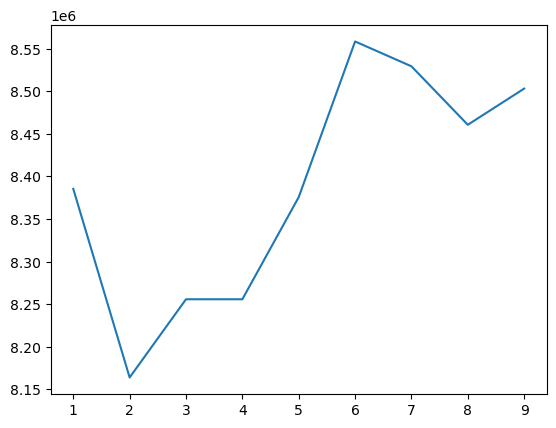

In [23]:
# 시각화 
plt.plot(selected_varnum, score_list)

In [24]:
# 상위 2개의 변수만 사용했을 때 mse가 가장 낮음
# 상위 두개 변수 promo와 weekday만 사용한 모델 학습

xgb.fit(train[['Promo','weekday']],
        train['Sales'])
test['Sales'] = xgb.predict(test[['Promo','weekday']])
test[['id','Sales']].to_csv("submission1.csv",index=False) 

In [25]:
# 외부 Data 사용하기

print(store.head())
print(store.info())

   Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,

In [27]:
# 외부 데이터와 결합

train = pd.merge(train, store, on=['Store'], how='left')
test = pd.merge(test, store, on=['Store'], how='left')

In [28]:
train.head()

,id,Store,Date,Sales,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,...,weekday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,14929,85,2015-05-01,11360,1,0,0,1,0,0,...,4,b,a,1870.0,10.0,2011.0,0,NaN,NaN,NaN
1,14930,512,2015-05-01,10534,1,0,0,1,0,0,...,4,b,b,590.0,NaN,NaN,1,5.0,2013.0,"Mar,Jun,Sept,Dec"
2,14931,1097,2015-05-01,17039,1,0,0,1,0,0,...,4,b,b,720.0,3.0,2002.0,0,NaN,NaN,NaN
3,14932,1,2015-04-30,6228,1,0,1,0,0,0,...,3,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,14933,9,2015-04-30,9717,1,0,1,0,0,0,...,3,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN


In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62244 entries, 0 to 62243
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         62244 non-null  int64         
 1   Store                      62244 non-null  int64         
 2   Date                       62244 non-null  datetime64[ns]
 3   Sales                      62244 non-null  int64         
 4   Promo                      62244 non-null  int64         
 5   SchoolHoliday              62244 non-null  int64         
 6   StateHoliday_0             62244 non-null  uint8         
 7   StateHoliday_a             62244 non-null  uint8         
 8   StateHoliday_b             62244 non-null  uint8         
 9   StateHoliday_c             62244 non-null  uint8         
 10  year                       62244 non-null  int64         
 11  month                      62244 non-null  int64         
 12  week

In [29]:
# FE 를 통한 새로운 변수 생성
# CompetitionOpenSinceYear : 경쟁업체가 오픈한 년도
# CompetitionOpenSinceMonth : 경쟁업체가 오픈한 월

# CompetitionOpen : 경쟁업체가 몇 개월 전에 오픈했는지 확인

train['CompetitionOpen'] = 12*( train['year'] - train['CompetitionOpenSinceYear'] ) + \
                             (train['month'] - train['CompetitionOpenSinceMonth'])

test['CompetitionOpen'] = 12*( test['year'] - test['CompetitionOpenSinceYear'] ) + \
                             (test['month'] - test['CompetitionOpenSinceMonth'])

In [30]:
# 경쟁업체 오픈을 몇 번째 주에 했는지 확인

train['WeekOfYear'] = train['Date'].dt.weekofyear
test['WeekOfYear'] = test['Date'].dt.weekofyear

In [31]:
# 경쟁업체 프로모션을 시작한지 몇 개월이 되었는지 확인

train['PromoOpen'] = 12* ( train['year'] - train['Promo2SinceYear'] ) + \
                        (train['WeekOfYear'] - train['Promo2SinceWeek']) / 4

test['PromoOpen'] = 12* ( test['year'] - test['Promo2SinceYear'] ) + \
                        (test['WeekOfYear'] - test['Promo2SinceWeek']) / 4

In [33]:
## StoreType 변수를 one hot encoding 

train = pd.get_dummies(columns=['StoreType'],data=train)
test = pd.get_dummies(columns=['StoreType'],data=test)

In [34]:
## Assortment 변수를 one hot encoding

train = pd.get_dummies(columns=['Assortment'],data=train)
test = pd.get_dummies(columns=['Assortment'],data=test)

In [35]:
## PromoInterval 변수를 one hot encoding

train = pd.get_dummies(columns=['PromoInterval'],data=train)
test = pd.get_dummies(columns=['PromoInterval'],data=test)

In [36]:
train.columns

Index(['id', 'Store', 'Date', 'Sales', 'Promo', 'SchoolHoliday',
       'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c',
       'year', 'month', 'weekday', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'CompetitionOpen', 'WeekOfYear',
       'PromoOpen', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d',
       'Assortment_a', 'Assortment_b', 'Assortment_c',
       'PromoInterval_Feb,May,Aug,Nov', 'PromoInterval_Jan,Apr,Jul,Oct',
       'PromoInterval_Mar,Jun,Sept,Dec'],
      dtype='object')

In [37]:
# 2차 모델링
# 사용할 변수 저장

col = ['Promo', 'SchoolHoliday',
       'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c',
       'weekday', 'year', 'month', 'CompetitionDistance',
       'Promo2',
       'CompetitionOpen', 'WeekOfYear',
       'PromoOpen', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d',
       'Assortment_a', 'Assortment_b', 'Assortment_c',
       'PromoInterval_Feb,May,Aug,Nov', 'PromoInterval_Jan,Apr,Jul,Oct',
       'PromoInterval_Mar,Jun,Sept,Dec']

In [39]:
xgb = XGBRegressor( n_estimators=300, learning_rate= 0.1, random_state=2022)
xgb.fit(train[col],train['Sales'])

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=2022, ...)

In [40]:
xgb.feature_importances_

array([0.12385487, 0.03988599, 0.00907444, 0.00132656, 0.00120433,
       0.00220948, 0.02616483, 0.01552788, 0.04393972, 0.08632533,
       0.06617997, 0.05349968, 0.02579216, 0.03712471, 0.06036671,
       0.03335419, 0.0622099 , 0.0484133 , 0.09887119, 0.0033941 ,
       0.03573428, 0.02701863, 0.07613375, 0.02239397], dtype=float32)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

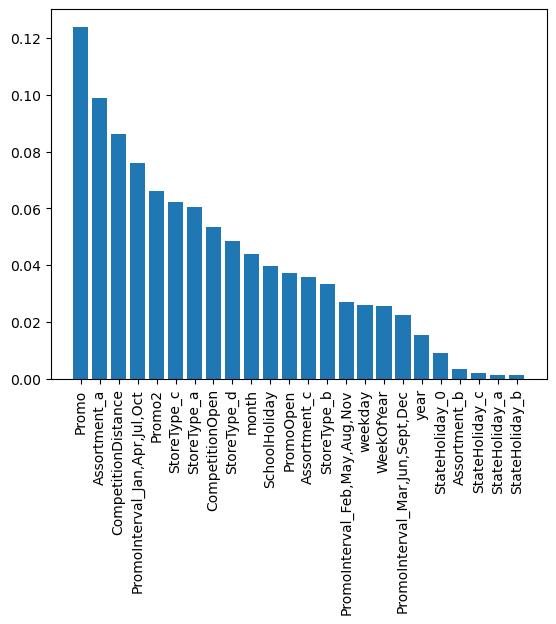

In [45]:
# 변수 중요도 확인
imp_df = pd.DataFrame({"var" : col,
                      "imp": xgb.feature_importances_})

imp_df = imp_df.sort_values(by="imp", ascending=False)

plt.bar(imp_df["var"], imp_df["imp"])
plt.xticks(rotation=90)

In [49]:
# 교차 검증과 변수를 늘려가면서 mse 확인
score_list = []
selected_varnum = []

for i in range(len(imp_df)):
    selected_var = imp_df["var"].to_list()[:i+1]
    scores = cross_val_score(xgb,
                            train[selected_var],
                            train['Sales'],
                            scoring="neg_mean_squared_error", cv=3)
    
    score_list.append(-np.mean(scores))
    selected_varnum.append(i+1)
    
    print(f'{i+1}번째 변수까지의 학습 완료')
    

1번째 변수까지의 학습 완료
2번째 변수까지의 학습 완료
3번째 변수까지의 학습 완료
4번째 변수까지의 학습 완료
5번째 변수까지의 학습 완료
6번째 변수까지의 학습 완료
7번째 변수까지의 학습 완료
8번째 변수까지의 학습 완료
9번째 변수까지의 학습 완료
10번째 변수까지의 학습 완료
11번째 변수까지의 학습 완료
12번째 변수까지의 학습 완료
13번째 변수까지의 학습 완료
14번째 변수까지의 학습 완료
15번째 변수까지의 학습 완료
16번째 변수까지의 학습 완료
17번째 변수까지의 학습 완료
18번째 변수까지의 학습 완료
19번째 변수까지의 학습 완료
20번째 변수까지의 학습 완료
21번째 변수까지의 학습 완료
22번째 변수까지의 학습 완료
23번째 변수까지의 학습 완료
24번째 변수까지의 학습 완료


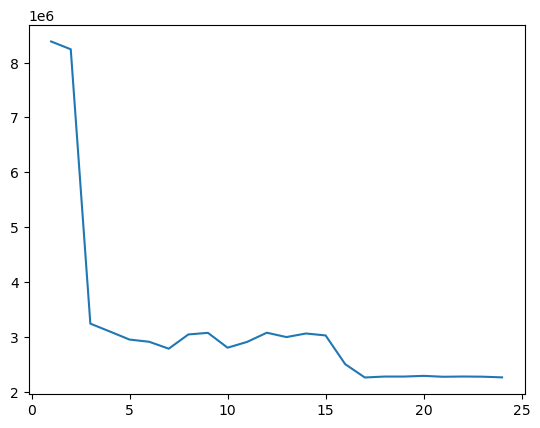

In [50]:
plt.plot(selected_varnum, score_list)

In [51]:
# 변수 중요도의 상위 17개 변수만을 사용하여 모델 학습 

xgb.fit(train[col[16]], train['Sales'])
test['Sales'] = xgb.predict(test[col[16]])

test[['id','Sales']].to_csv("submission2.csv",index=False)

In [61]:
# 하이퍼 파라미터 튜닝
# n_estimators : 트리의 개수

est_list = [x for x in range(100, 1000, 100)]
score_list = []

for i in est_list:
    xgb = XGBRegressor( n_estimators=i, learning_rate= 0.1, random_state=2022)
    scores = cross_val_score(xgb, train[col[:17]], train['Sales'], scoring="neg_mean_squared_error", cv=3)
    score_list.append(-np.mean(scores))
    print(f'est : {i} / socre = {-np.mean(scores)}')

est : 100 / socre = 3141404.4479315304
est : 200 / socre = 2524316.9747549575
est : 300 / socre = 2360528.8613714096
est : 400 / socre = 2294433.52211088
est : 500 / socre = 2259368.3690144885
est : 600 / socre = 2235471.039666451
est : 700 / socre = 2226403.4475525036
est : 800 / socre = 2220508.216998303
est : 900 / socre = 2218466.266808203


(array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

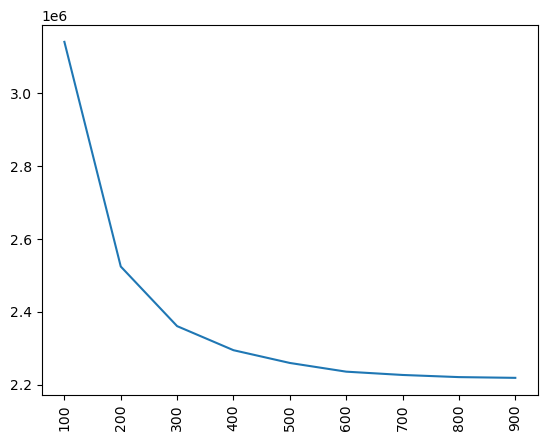

In [62]:
plt.plot(est_list,score_list)
plt.xticks(rotation=90)

In [ ]:
# 최적의 tree 개수는 300